### Code Hist.

 - CODE : KIER M02 - Clustering
 - DESC  
    &ensp; : 최적의 Cluster를 선정하기 위한 정량적 비교  
    &emsp; 1) Inertia 기반의 Elbow-Method  
    &emsp; 2) 군집화 계수 비교 : Silhouette / CHI / Dunn Index  

  - DATE  
    &ensp; 2024-02-01 Created  
    &ensp; 2024-04-03 코드 개선  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) KIER M02 초기부분 공통코드화  
    &ensp; 2024-04-04 Updated  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) 기능 구현 완료 및 논문 작성    
    &ensp; 2024-07-23 Updated  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1) Dunn Index 부분 추가    

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [77]:
#region Basic_Import
## Basic
import os, sys, warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.path.dirname(os.path.abspath('./__file__'))
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('./__file__'))))
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
from pandas import DataFrame, Series
pd.options.display.float_format = '{:.10f}'.format

import math, random

## Datetime
import time, datetime as dt
from datetime import datetime, date, timedelta

## glob
import glob, requests, json
from glob import glob

## 시각화
import matplotlib.pyplot as plt, seaborn as sns
# %matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## Split, 정규화
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# K-Means 알고리즘
from sklearn.cluster import KMeans, MiniBatchKMeans

# Clustering 알고리즘의 성능 평가 측도
from sklearn import metrics
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, silhouette_score, rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import contingency_matrix

## For Web
import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

import tqdm
from tqdm.notebook import tqdm
#endregion Basic_Import

In [78]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch, torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf, tensorflow_addons as tfa
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.models import Sequential, load_model
    from keras_flops import get_flops
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [79]:
## Import_Local
from Src_Dev_Common import Data_Datetime as com_date, KMA_Weather as com_KMA, KECO_AirKor as com_KECO, KASI_Holiday as com_Holi, KIER_Usage_M02 as com_KIER_M02, Data_Clustering as com_clustering

### 01-01-02. Config (Directory, Params)

In [80]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"], os.environ['TF_DETERMINISTIC_OPS'] = str(SEED), "1"

In [81]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y, str_now_m, str_now_d = pd.datetime.now().year, pd.datetime.now().month, pd.datetime.now().day
str_now_hr, str_now_min = pd.datetime.now().hour, pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2024-08-12 18:35:09.535132
2024 / 8 / 12
18 : 35


In [82]:
## Dict_Domain
## {0:"ELEC", 1:"HEAT", 2:"WATER", 3:"HOT_HEAT", 4:"HOT_FLOW", 99:"GAS"}
## {0 : '10MIN', 1 : '30MIN', 2 : '1H', 3 : '12H', 4 : '1D', 5 : '1W', 6 : '2W', 7 : '1M'}
int_domain, int_interval = 0, 7

## Domain, ACCU/INST Column
str_domain, str_col_accu, str_col_inst = com_KIER_M02.create_domain_str(int_domain)
## Directory Root
str_dirData, str_dir_raw, str_dir_cleansed, str_dirName_bld, str_dirName_h = com_KIER_M02.create_dir_str(str_domain)
## Interval, Target File
str_interval, str_fileRaw, str_fileRaw_hList, str_file = com_KIER_M02.create_file_str(str_domain, int_interval)

print(str(os.listdir(str_dirData)) + "\n")
print(os.listdir(str_dirName_h))

0 : ELEC
str_fileRaw : KIER_RAW_ELEC_2024-06-07.csv
str_fileRaw_hList : KIER_RAW_ELEC_2024-06-07.csv
str_file : KIER_ELEC_INST_1M_Resampled.csv
['.ipynb_checkpoints', 'BS_CONFIGURATION_202309251452.csv', 'DATE_1M_2023-10-20.csv', 'KIER 전처리 현황_2024-06-25.xlsx', 'KIER_0_Raw', 'KIER_1_Cleansed', 'KIER_2_BLD', 'KIER_3_H_ELEC', 'KIER_3_H_GAS', 'KIER_3_H_HEAT', 'KIER_3_H_HOT_FLOW', 'KIER_3_H_HOT_HEAT', 'KIER_3_H_WATER', 'KIER_ASOS_WEATHER_DAILY_202309251521.csv', 'KIER_ASOS_WEATHER_HOUR_202309251521.csv', 'KIER_DATA_OLD', 'KIER_ETC', 'KIER_hList_Comparison_2024-06-26.xlsx', 'KIER_List_Table_Column_2023-09-25.xlsx', 'KIER_Query_2023-09-25.txt', 'KMA_ASOS_119_2010_2023_1st_to CSV.csv', '[IITP] 데이터 테이블 정리 (공유 원본).docx']

['KIER_ELEC_561-1-1_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-2_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-3_ACCU_01_Raw.csv', 'KIER_ELEC_561-1-4_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-1_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-2_ACCU_01_Raw.csv', 'KIER_ELEC_561-10-3_ACCU_01_Raw.csv', 'KIER_ELEC_561-

## 01-02. Data Load (df_raw)

### 01-02-01. KIER (Energy Usage)

In [83]:
df_kier_raw = pd.read_csv(str_dirName_h + str_file, index_col = 0)

try : df_kier_raw['METER_DATE'] = pd.to_datetime(df_kier_raw['METER_DATE'])
except KeyError : df_kier_raw = com_date.create_col_datetime(df_kier_raw, 'METER_DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE').drop(labels = ['None'], axis = 1)

print(df_kier_raw.isna().sum().sum())
df_kier_raw

0


,METER_DATE,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,ELEC_INST_EFF_561-2-1,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-3,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-1,...,ELEC_INST_EFF_563-22-3,ELEC_INST_EFF_563-22-4,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2
0,2022-07-31,619.5626879811,578.9300154021,384.6375961427,759.7088960165,258.6082360466,318.6867770149,403.5431447588,365.7373363494,504.5822249604,...,515.7009910852,463.2699938177,446.7636297462,411.4999913417,451.9958185838,432.6127482092,391.9179467843,344.6114494831,317.5969251523,434.6494476175
1,2022-08-31,493.5213737215,388.6948123340,290.6491531306,478.0804712890,484.6898323471,195.8666305626,277.1988484038,263.5611467726,336.6490188551,...,278.2659034060,279.5883384353,274.3884485769,257.4296806457,235.6773966947,360.8081661933,285.6190297813,212.5566118292,240.3184483658,302.2796374644
2,2022-09-30,459.1360357173,363.3433365173,309.5728265953,353.1784717987,483.1546413424,205.4333684301,281.8032128061,267.1626415479,291.2455255813,...,251.1514084573,243.7260499647,264.5905612879,248.6810463850,235.2280848562,357.5343115427,284.4850765674,209.0393060298,222.3646077812,268.8752679308
3,2022-10-31,389.7472423264,343.2689537958,305.5790057785,322.7423460241,451.7595768764,226.3059014440,266.3530921247,258.2322150038,276.6887492090,...,245.0351761031,227.3978358216,243.7971651397,242.3425930382,235.3488154768,347.9697900841,258.8871330708,210.0750089783,251.7928385303,297.7497249955
4,2022-11-30,345.8231457844,329.1450972835,360.9811796051,359.7796611758,572.5818985891,215.6421376776,288.3314128886,272.6283034592,361.6592861594,...,231.9417333416,267.4305676384,261.9227423527,230.3184396080,306.4565469264,390.0438079980,279.4831253470,208.0717887111,257.5199133970,302.1554822285
5,2022-12-31,373.1313383428,360.5238475558,343.3463077419,348.5998720838,476.7335723069,212.0921200342,314.5473987207,262.3337773865,428.6635299146,...,230.4326809072,261.5193598540,246.7949076065,243.5793665907,268.1071883489,433.9614096587,285.9976063345,216.3794013712,251.4548079045,278.5883432288
6,2023-01-31,325.1991426281,336.5851714644,305.7082573284,303.6812112504,440.0117070898,193.3383004448,272.4777936041,209.2579356700,379.3405889625,...,206.2777264866,214.0015836610,242.3349673931,218.3885188236,234.1292293436,377.4693401684,250.2497710341,176.3884970507,238.8972326608,257.1861578011
7,2023-02-28,388.2689795176,334.4456674597,296.9745431271,367.2287960595,461.4981549056,225.5776897108,292.1498628061,213.4211695873,350.2856131898,...,219.2530064562,239.1194966904,305.7254025059,242.2089922456,235.4558988106,423.6412996667,267.2384296577,198.8252844686,239.4768391839,295.5011131379
8,2023-03-31,300.5605146671,312.5033660281,293.1309408113,365.6103942694,386.6992081718,222.1065143329,252.6200485430,215.5529617908,250.3148163802,...,222.9498278098,231.3346529101,279.7027357980,242.5889532005,258.8285339275,378.9630840106,265.3240086497,189.5017695317,221.8412054619,289.1110829997
9,2023-04-30,461.6828437725,337.3810686387,309.7137156113,439.0819303217,446.7764306202,224.1129149497,257.5074756051,249.9963114505,255.4488169164,...,246.8273131805,236.2022726939,287.1371423186,235.0246233419,247.9830470323,359.6611727003,266.3590144621,200.8026172691,237.2953867937,285.9271275397


In [84]:
## 호실별 순시 사용량 컬럼만 가져오기
list_col_tar = list(df_kier_raw.columns[6:-2])
df_kier_h = df_kier_raw.set_index('METER_DATE')
df_kier_h

,ELEC_INST_EFF_561-1-1,ELEC_INST_EFF_561-1-2,ELEC_INST_EFF_561-1-3,ELEC_INST_EFF_561-1-4,ELEC_INST_EFF_561-2-1,ELEC_INST_EFF_561-2-2,ELEC_INST_EFF_561-2-3,ELEC_INST_EFF_561-2-4,ELEC_INST_EFF_561-3-1,ELEC_INST_EFF_561-3-2,...,ELEC_INST_EFF_563-22-3,ELEC_INST_EFF_563-22-4,ELEC_INST_EFF_563-22-5,ELEC_INST_EFF_563-22-6,ELEC_INST_EFF_563-23-1,ELEC_INST_EFF_563-23-2,ELEC_INST_EFF_563-23-3,ELEC_INST_EFF_563-23-4,ELEC_INST_EFF_563-24-1,ELEC_INST_EFF_563-24-2
METER_DATE,,,,,,,,,,,,,,,,,,,,,
2022-07-31,619.5626879811,578.9300154021,384.6375961427,759.7088960165,258.6082360466,318.6867770149,403.5431447588,365.7373363494,504.5822249604,222.9916837906,...,515.7009910852,463.2699938177,446.7636297462,411.4999913417,451.9958185838,432.6127482092,391.9179467843,344.6114494831,317.5969251523,434.6494476175
2022-08-31,493.5213737215,388.6948123340,290.6491531306,478.0804712890,484.6898323471,195.8666305626,277.1988484038,263.5611467726,336.6490188551,196.0355335293,...,278.2659034060,279.5883384353,274.3884485769,257.4296806457,235.6773966947,360.8081661933,285.6190297813,212.5566118292,240.3184483658,302.2796374644
2022-09-30,459.1360357173,363.3433365173,309.5728265953,353.1784717987,483.1546413424,205.4333684301,281.8032128061,267.1626415479,291.2455255813,200.5054416560,...,251.1514084573,243.7260499647,264.5905612879,248.6810463850,235.2280848562,357.5343115427,284.4850765674,209.0393060298,222.3646077812,268.8752679308
2022-10-31,389.7472423264,343.2689537958,305.5790057785,322.7423460241,451.7595768764,226.3059014440,266.3530921247,258.2322150038,276.6887492090,176.3178437579,...,245.0351761031,227.3978358216,243.7971651397,242.3425930382,235.3488154768,347.9697900841,258.8871330708,210.0750089783,251.7928385303,297.7497249955
2022-11-30,345.8231457844,329.1450972835,360.9811796051,359.7796611758,572.5818985891,215.6421376776,288.3314128886,272.6283034592,361.6592861594,170.7131393845,...,231.9417333416,267.4305676384,261.9227423527,230.3184396080,306.4565469264,390.0438079980,279.4831253470,208.0717887111,257.5199133970,302.1554822285
2022-12-31,373.1313383428,360.5238475558,343.3463077419,348.5998720838,476.7335723069,212.0921200342,314.5473987207,262.3337773865,428.6635299146,168.7328260159,...,230.4326809072,261.5193598540,246.7949076065,243.5793665907,268.1071883489,433.9614096587,285.9976063345,216.3794013712,251.4548079045,278.5883432288
2023-01-31,325.1991426281,336.5851714644,305.7082573284,303.6812112504,440.0117070898,193.3383004448,272.4777936041,209.2579356700,379.3405889625,149.9562290520,...,206.2777264866,214.0015836610,242.3349673931,218.3885188236,234.1292293436,377.4693401684,250.2497710341,176.3884970507,238.8972326608,257.1861578011
2023-02-28,388.2689795176,334.4456674597,296.9745431271,367.2287960595,461.4981549056,225.5776897108,292.1498628061,213.4211695873,350.2856131898,160.0998268248,...,219.2530064562,239.1194966904,305.7254025059,242.2089922456,235.4558988106,423.6412996667,267.2384296577,198.8252844686,239.4768391839,295.5011131379
2023-03-31,300.5605146671,312.5033660281,293.1309408113,365.6103942694,386.6992081718,222.1065143329,252.6200485430,215.5529617908,250.3148163802,163.6869237835,...,222.9498278098,231.3346529101,279.7027357980,242.5889532005,258.8285339275,378.9630840106,265.3240086497,189.5017695317,221.8412054619,289.1110829997


In [85]:
# ## Error Log : "[5:-2]" 부분을 추가하여 연월일시 및 평균합계 부분을 제거해주지 않으면, 군집화 계수가 제대로 도출되지 못함.
# df_kier_summary_total = df_kier_h.transpose().reset_index()[5:-2]
# ## 또는, 가장 깔끔하게 이렇게 처리해도 좋다
df_kier_summary_total = df_kier_h[list_col_tar].transpose().reset_index()

## 세대 번호의 컬럼명이 'index'로 지정되어 오류 발생
df_kier_summary_total['h_index'] = df_kier_summary_total['index']
df_kier_summary_total = df_kier_summary_total.drop(columns = ['index'])
df_kier_summary_total

METER_DATE,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00,2023-01-31 00:00:00,2023-02-28 00:00:00,2023-03-31 00:00:00,2023-04-30 00:00:00,...,2023-09-30 00:00:00,2023-10-31 00:00:00,2023-11-30 00:00:00,2023-12-31 00:00:00,2024-01-31 00:00:00,2024-02-29 00:00:00,2024-03-31 00:00:00,2024-04-30 00:00:00,2024-05-31 00:00:00,h_index
0,318.6867770149,195.8666305626,205.4333684301,226.3059014440,215.6421376776,212.0921200342,193.3383004448,225.5776897108,222.1065143329,224.1129149497,...,209.0387558696,207.3567672086,217.2579200668,231.4451408103,192.9998914639,211.6190514208,188.3273930344,186.1316175459,32.2257111038,ELEC_INST_EFF_561-2-2
1,403.5431447588,277.1988484038,281.8032128061,266.3530921247,288.3314128886,314.5473987207,272.4777936041,292.1498628061,252.6200485430,257.5074756051,...,256.8121113386,258.9339761116,313.2730199846,310.6347802222,269.2442000535,273.7142139882,275.2384809114,277.7422482001,41.6047749962,ELEC_INST_EFF_561-2-3
2,365.7373363494,263.5611467726,267.1626415479,258.2322150038,272.6283034592,262.3337773865,209.2579356700,213.4211695873,215.5529617908,249.9963114505,...,251.0016143925,222.4686905158,225.2105090950,300.0098297170,289.0201650585,282.1140176313,277.5452225025,328.3825727655,40.1740371026,ELEC_INST_EFF_561-2-4
3,504.5822249604,336.6490188551,291.2455255813,276.6887492090,361.6592861594,428.6635299146,379.3405889625,350.2856131898,250.3148163802,255.4488169164,...,277.0763057174,287.3329627928,323.2865541924,365.0523416367,351.5262795590,334.6813203863,266.4846864764,266.4130861415,39.1629814422,ELEC_INST_EFF_561-3-1
4,222.9916837906,196.0355335293,200.5054416560,176.3178437579,170.7131393845,168.7328260159,149.9562290520,160.0998268248,163.6869237835,186.6782028440,...,201.9016621982,171.7174111933,177.1838739485,175.9714246324,166.7784835626,178.8684532059,178.6493863531,117.5536808263,5.2522583863,ELEC_INST_EFF_561-3-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,411.4999913417,257.4296806457,248.6810463850,242.3425930382,230.3184396080,243.5793665907,218.3885188236,242.2089922456,242.5889532005,235.0246233419,...,230.3807273185,238.7094130329,253.7654963236,261.2349224723,228.5579386674,240.9973398264,241.7387601630,261.8250811619,35.4130709062,ELEC_INST_EFF_563-22-6
337,451.9958185838,235.6773966947,235.2280848562,235.3488154768,306.4565469264,268.1071883489,234.1292293436,235.4558988106,258.8285339275,247.9830470323,...,262.2599842179,277.5693950138,263.5996270947,255.4699213948,243.8335463959,255.6636643272,216.6780080481,237.3618929952,41.3446008038,ELEC_INST_EFF_563-23-1
338,432.6127482092,360.8081661933,357.5343115427,347.9697900841,390.0438079980,433.9614096587,377.4693401684,423.6412996667,378.9630840106,359.6611727003,...,390.9371133064,420.7424078660,441.1731141085,456.5056181108,436.5012990843,431.5222873395,361.2660470699,343.6072175905,47.0802422803,ELEC_INST_EFF_563-23-2
339,391.9179467843,285.6190297813,284.4850765674,258.8871330708,279.4831253470,285.9976063345,250.2497710341,267.2384296577,265.3240086497,266.3590144621,...,268.9675680093,264.2299849151,299.4235245879,281.6370184673,259.7394294869,231.5753900594,219.1995170012,219.3716292691,29.7617381724,ELEC_INST_EFF_563-23-3


In [86]:
X = df_kier_summary_total.drop(columns = 'h_index')
y = df_kier_summary_total['h_index']
X.isna().sum()
# y

METER_DATE
2022-07-31 00:00:00    0
2022-08-31 00:00:00    0
2022-09-30 00:00:00    0
2022-10-31 00:00:00    0
2022-11-30 00:00:00    0
2022-12-31 00:00:00    0
2023-01-31 00:00:00    0
2023-02-28 00:00:00    0
2023-03-31 00:00:00    0
2023-04-30 00:00:00    0
2023-05-31 00:00:00    0
2023-06-30 00:00:00    0
2023-07-31 00:00:00    0
2023-08-31 00:00:00    0
2023-09-30 00:00:00    0
2023-10-31 00:00:00    0
2023-11-30 00:00:00    0
2023-12-31 00:00:00    0
2024-01-31 00:00:00    0
2024-02-29 00:00:00    0
2024-03-31 00:00:00    0
2024-04-30 00:00:00    0
2024-05-31 00:00:00    0
dtype: int64

http://bigdata.dongguk.ac.kr/lectures/datascience/_book/%EA%B5%B0%EC%A7%91%EB%B6%84%EC%84%9D.html

In [87]:
# 변수 표준화
scaler = StandardScaler() # 변수 표준화 클래스
scaler.fit(X)  # 표준화를 위해 변수별 파라미터(평균, 표준편차) 계산
# scaler.mean_, scaler.scale_
X_std = scaler.transform(X)  # 훈련자료 표준화 변환
# X_std

### Clustering (군집화) : K - Means

군집의 수 결정 방법  
1) elbow method - 군집의 개수와 군집내 변동의 합을 그래프로 나타내고, 변동량의 변화가 작아지는 지점의 군집의 수를 적정 군집의 수로 결정함  
2) 군집화시 계수 비교 : Silhouette / CHI

In [88]:
## 군집시 군집의 수 판단을 위한 Data 수집, 이를 바탕으로 인사이트 도출
int_cluster_min, int_cluster_max = 2, 10 ## 최소 / 최대 군집 수

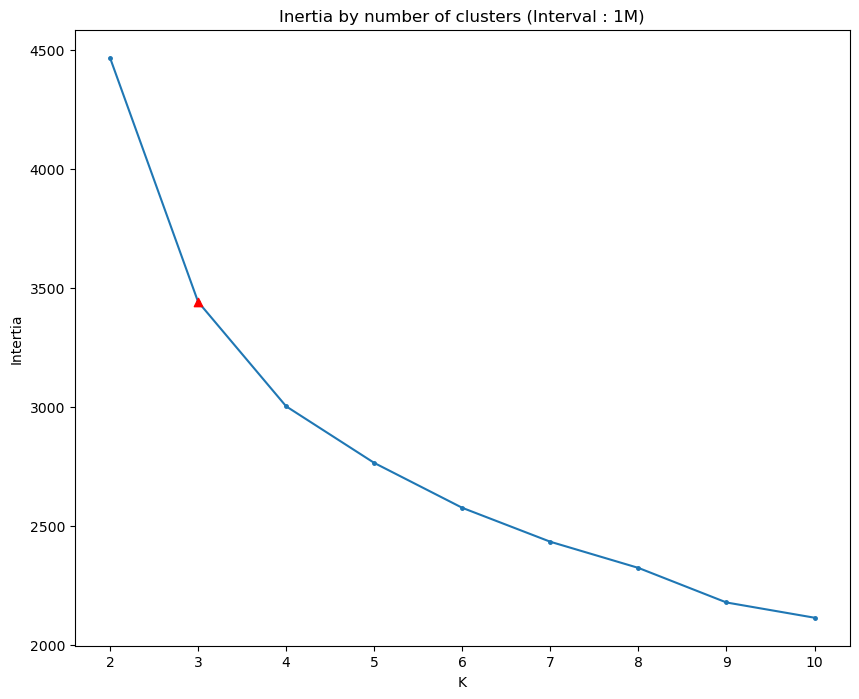

[4466.60504059709, 3441.542325251559, 3002.641773788882, 2765.0065066415805, 2576.3551101890084, 2433.8245180350004, 2323.983734742546, 2178.8133997019586, 2114.801965553932]
[1025.0627153455312, 438.90055146267696, 237.63526714730142, 188.65139645257204, 142.530592154008, 109.84078329245449, 145.17033504058736, 64.01143414802664]


In [89]:
list_intertia, list_intertia_deriv = com_clustering.clustering_elbow_method(str_interval, int_cluster_min, int_cluster_max, X_std, opt_X = 3)
print(list_intertia)
print(list_intertia_deriv)

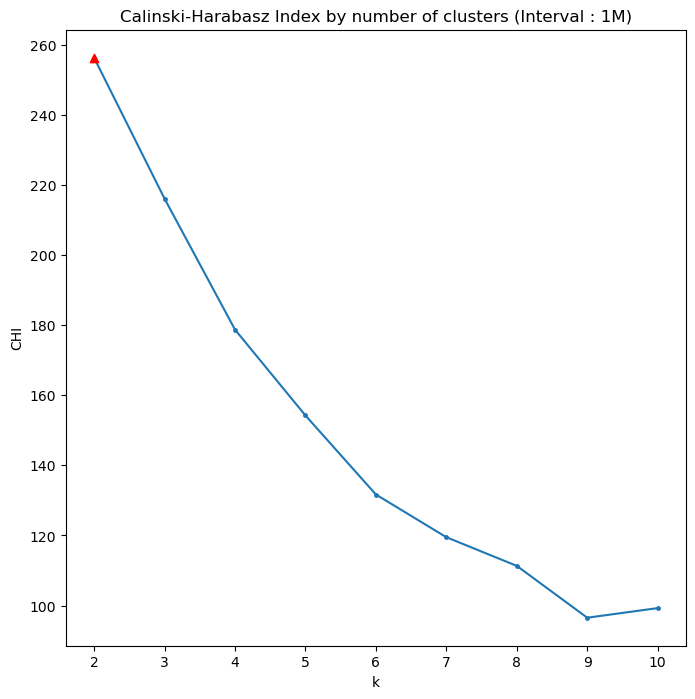

[256.25679477686185, 216.06049631507472, 178.70527399251932, 154.21513504186638, 131.67219506981442, 119.48986862526488, 111.31128513666121, 96.52618011262136, 99.2702980338572]


In [90]:
list_CHI = com_clustering.clustering_CHI_method(str_interval, int_cluster_min, int_cluster_max, X_std, 2)
print(list_CHI)

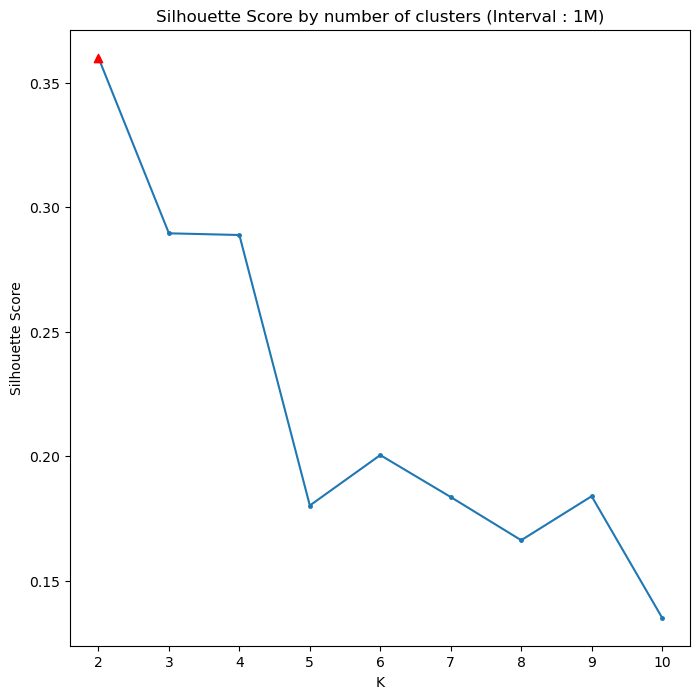

[0.3600420538665685, 0.2895318235453918, 0.28885599883493274, 0.18023201618218607, 0.20048075973296234, 0.1836327789186868, 0.16628744593203337, 0.18395531157120928, 0.13517191969466671]
[[203, 138], [164, 121, 56], [4, 159, 77, 101], [82, 101, 35, 70, 53], [7, 35, 32, 68, 102, 97], [95, 95, 48, 38, 5, 30, 30], [36, 15, 52, 98, 20, 69, 47, 4], [2, 88, 32, 38, 56, 30, 5, 6, 84], [75, 18, 63, 5, 29, 24, 23, 66, 21, 17]]


In [91]:
list_Silhouette, list_cnt_clusters_by_K = com_clustering.clustering_Silhouette_method(str_interval, int_cluster_min, int_cluster_max, X_std, 2)
print(list_Silhouette)
print(list_cnt_clusters_by_K)

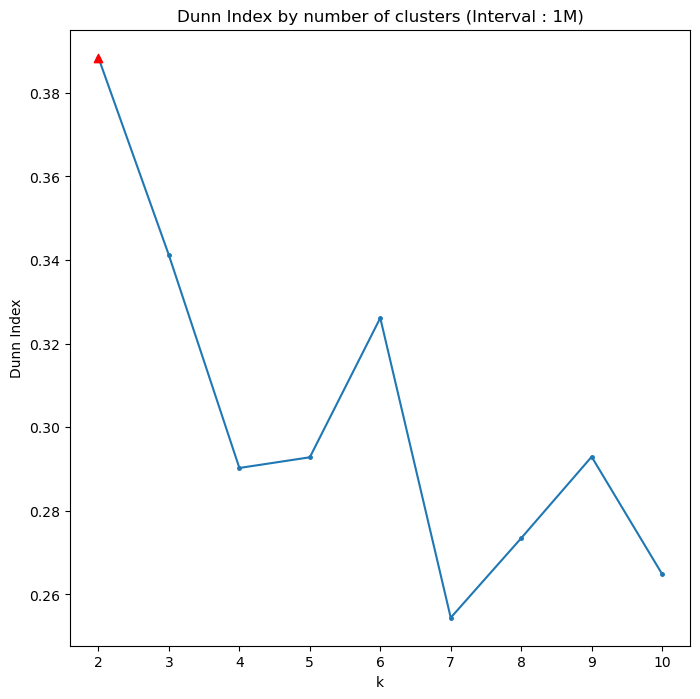

[0.3884209585575717, 0.34115978923451323, 0.2902522183821388, 0.29280883305125, 0.3261489027002681, 0.25441780207292614, 0.2734509792499263, 0.2929303989683452, 0.26486561363094285]


In [92]:
from Src_Dev_Common.cluster_eval import get_Dunn_index

opt_X = 2

## 예외처리01
## Min이 Max보다 크면 그냥 바꿔줌 + Int가 아니면 Int로 바꿔줌
if int_cluster_min > int_cluster_max : int_clusters_min, int_clusters_max = int(int_cluster_max), int(int_cluster_min) + 1
else : int_clusters_min, int_clusters_max = int(int_cluster_min), int(int_cluster_max) + 1

## 초기 변수  생성
list_Dunn = []
K = range(int_clusters_min, int_clusters_max)

for n_cluster in K:
    km_dunn = KMeans(n_clusters = n_cluster, init="k-means++", max_iter=300, n_init=1).fit(X_std) 
    cluster = km_dunn.predict(X_std)
    list_Dunn.append(get_Dunn_index(X_std, cluster))

fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
ax.plot(K, list_Dunn, marker='.', markersize = 5, zorder = 2)
if opt_X != None : plt.scatter(opt_X, list_Dunn[opt_X - 2], color = 'red', marker = '^', label = 'Point', zorder = 9999)
ax.set_xticks(K)
plt.xlabel('k')
plt.ylabel('Dunn Index')
plt.title('Dunn Index by number of clusters (Interval : ' + str_interval + ')')
plt.show()

print(list_Dunn)

## 선정된 군집의 수에 따라 군집화 시뮬레이션 시행

In [93]:
## 위에서 결정된 군집의 수에 따라 군집화 결과 도출
## 초기 변수 생성
K, cnt_loop = 3, 10 ## K : 결정된/평가할 군집의 수, cnt_loop : 평가를 위한 군집화 시도 횟수

km = KMeans(n_clusters = K, init="k-means++", max_iter=300, n_init=1).fit(X_std)
cluster = km.predict(X_std)

list_log_clusters = com_clustering.clustering_get_cnt_by_loop(K, cnt_loop, X_std)
print("총 " + str(cnt_loop) + "회에 걸친 군집화 시뮬레이션")
print(list_log_clusters)

총 10회에 걸친 군집화 시뮬레이션
[[168, 82, 91], [91, 82, 168], [166, 81, 94], [166, 81, 94], [121, 164, 56], [121, 56, 164], [165, 95, 81], [82, 168, 91], [91, 168, 82], [168, 77, 96]]


[168, 82, 91]


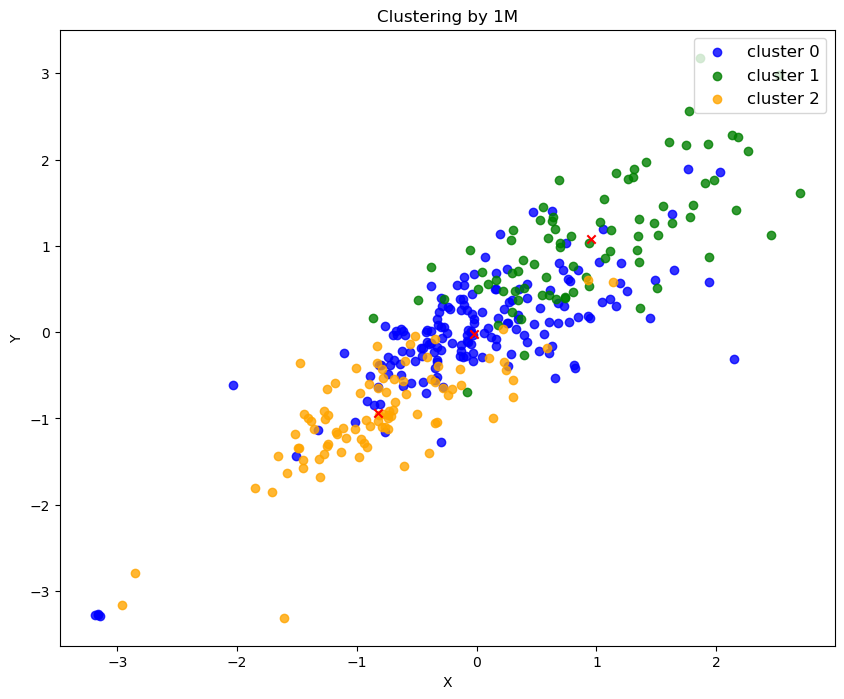

Silhouette Coefficient: 0.2819
Calinski and Harabasz score: 216.0605
Dunn Index : 0.3412
Davues Bouldin Score: 1.1121
Homogeneity: 0.1790
Completeness: 1.0000
V-measure: 0.3037
Rand-Index: 0.6301
Adjusted Rand-Index: 0.0000


In [94]:
## 최종 군집에 대한 군집화 평가
print(com_clustering.get_cluster_sizes(km, X_std)) ## 최종 군집화에 대한 군집 크기 출력

com_clustering.clustering_visualization(str_interval, km, X_std)
list_scores = com_clustering.get_clustring_score(km, X_std, y)

In [95]:
## 최종 군집에 대한 Labeled Data 저장
print(com_clustering.get_cluster_sizes(km, X_std)) ## 최종 군집화에 대한 군집 크기 출력
# df_kier_summary_total['target'] = np.transpose(np.where(km.labels_ == i)[0])
df_kier_summary_total['target_'+str_domain] = 0
for i in range(0, len(df_kier_summary_total)) : df_kier_summary_total['target_'+str_domain].iloc[i] = km.labels_[i]
# df_kier_summary_total[['h_index', 'target_' + str_domain]]

str_file_labeled = str_dirName_h + 'KIER_' + str(str_domain) + '_Labeled_' + str_interval + '_K' + str(K) + '.csv'
df_kier_summary_total = df_kier_summary_total[['h_index', 'target_'+str_domain]]
df_kier_summary_total.to_csv(str_file_labeled)
print(str_file_labeled)
df_kier_summary_total

[56, 164, 121]
../data_Energy_KIER/KIER_3_H_ELEC/KIER_ELEC_Labeled_1M_K3.csv


METER_DATE,h_index,target_ELEC
0,ELEC_INST_EFF_561-2-2,2
1,ELEC_INST_EFF_561-2-3,1
2,ELEC_INST_EFF_561-2-4,1
3,ELEC_INST_EFF_561-3-1,1
4,ELEC_INST_EFF_561-3-2,2
...,...,...
336,ELEC_INST_EFF_563-22-6,1
337,ELEC_INST_EFF_563-23-1,1
338,ELEC_INST_EFF_563-23-2,0
339,ELEC_INST_EFF_563-23-3,1
